# An Introduction to Neural Networks
## 02 - Singlelayer Perceptron

<p>
    Esse é o nosso primeiro tutorial realmente sobre Redes Neurais! Nesse tutorial, iremos estudar a Rede Neural de camada-única mais simples: a Singlelayer Perceptron. <br>Mais específicamente, iremos aprender como:
</p>
<ul>
    <li>Desenvolver um algoritmo iterativo para treinar uma Rede Neural, adaptando seus pesos;</li>
    <li>Utilizar uma Rede Neural para realizar classificação binária em um dataset;</li>
</ul>

### Bibliotecas

In [1]:
import pandas as pd                 # <-- Representação e Manipulação dos Dados
import numpy as np                  # <-- Biblioteca para Operações Matriciais e Complexas
import matplotlib.pyplot as plt     # <-- Biblioteca para Visualização de Dados

# Essa linha abaixo é apenas para que os 
# plots sejam gerados na mesma célula do código
%matplotlib inline

### Dataset

<p>
    Neste tutorial, utilizaremos um dataset artificial, criado apenas para servir como base à explicação dos conceitos relacionados ao treino de Redes Neurais de camada-única. <br>
    
    O código abaixo já está pronto. Para mais detalhes sobre como resgatar e manipular dados de arquivos, refira-se ao Tutorial 01.
</p>

In [2]:
## CARREGANDO E PRÉ-PROCESSANDO OS DADOS ##
# Carregando os dados a partir do arquivo .csv
data = pd.read_csv("datasets/data_01.csv")

# Armazenando as dimensões dos dados
m = data.shape[0]
n = data.shape[1]-1

# Separação do Conjunto de Treino e Conjunto de Teste
trainingSize = int(0.8 * m)
indexes = np.random.randint(0, m, m)
trainData = data.iloc[indexes[:trainingSize]]
testData = data.iloc[indexes[trainingSize:]]

# Obtendo matrizes (formato Numpy) correspondentes
X_train = trainData.iloc[:,:-1].values
y_train = trainData.iloc[:, -1].values

X_test = testData.iloc[:,:-1].values
y_test = testData.iloc[:, -1].values

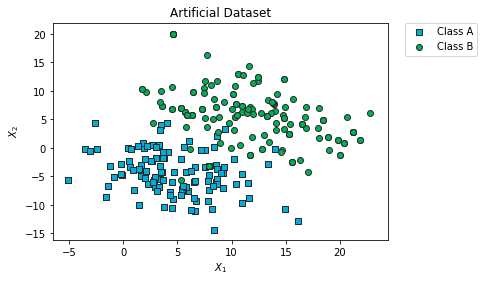

In [3]:
## VISUALIZAÇÃO CONDICIONADA COM O MATPLOTLIB E NUMPY ##
plt.figure()

a_class = np.where(y_train == "A")
b_class = np.where(y_train == "B")

plt.title("Artificial Dataset"); plt.xlabel("$X_1$"); plt.ylabel("$X_2$")

plt.scatter(X_train[a_class,0], X_train[a_class,1], marker="s", color="#00aedb", edgecolor="#2A2A2A", label="Class A")
plt.scatter(X_train[b_class,0], X_train[b_class,1], marker="o", color="#00b159", edgecolor="#2A2A2A", label="Class B")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [58]:
slp_predict([[1, 0, 0]], theta)

array([ 0.984736])

### Parte 1 -  Treinando uma Rede Neural

In [50]:
def sigmoid(z):
    return 1 / (1 + np.exp(z))

def slp_predict(X, theta):
    return sigmoid(np.matmul(X, theta.T))[:,0]

def slp_train(X, y, alpha=1e-1, maxIt=50000, tol=1e-4):
    m = X.shape[0]; n = X.shape[1]
    X = np.hstack([np.ones([m,1]), X])
    
    errorHist = []
    previousMSE = 0
    theta = np.random.randn(1, n+1)
    
    it = 1;
    while(it <= maxIt):
        predicts = slp_predict(X, theta)
        error = (y == "A") - predicts
        
        actualMSE = np.sum(error ** 2)
        theta -= (alpha/m) * (np.matmul(X.T, error))
        
        if(it % 50 == 0): 
            print("## Iteration", it, "##")
            print("Error: ", actualMSE)
            print("Thetas: ", theta.T)
            print("\n")
        
        if(abs(actualMSE - previousMSE) <= tol):
            print("## Iteration", it, "##")
            print("Convergence reached!")
            break;
            
        errorHist.append(actualMSE)
        previousMSE = actualMSE
        it +=1
        
    return (theta, errorHist)

[theta, errorHist] = slp_train(X_train, y_train)

## Iteration 50 ##
Error:  16.3875114366
Thetas:  [[-1.4524628 ]
 [ 0.20356048]
 [ 0.52261643]]


## Iteration 100 ##
Error:  15.7089796152
Thetas:  [[-1.62289201]
 [ 0.21900184]
 [ 0.52014514]]


## Iteration 150 ##
Error:  15.1682782259
Thetas:  [[-1.77719082]
 [ 0.23325695]
 [ 0.52040741]]


## Iteration 200 ##
Error:  14.724585869
Thetas:  [[-1.9176537 ]
 [ 0.24637098]
 [ 0.52151601]]


## Iteration 250 ##
Error:  14.356313466
Thetas:  [[-2.04616816]
 [ 0.25847474]
 [ 0.52318231]]


## Iteration 300 ##
Error:  14.0474455193
Thetas:  [[-2.16429358]
 [ 0.2696831 ]
 [ 0.52522669]]


## Iteration 350 ##
Error:  13.7858672782
Thetas:  [[-2.27332534]
 [ 0.28009498]
 [ 0.52752273]]


## Iteration 400 ##
Error:  13.5623297761
Thetas:  [[-2.37434623]
 [ 0.28979551]
 [ 0.52998042]]


## Iteration 450 ##
Error:  13.3697039674
Thetas:  [[-2.46826738]
 [ 0.29885809]
 [ 0.53253517]]


## Iteration 500 ##
Error:  13.2024404927
Thetas:  [[-2.55586062]
 [ 0.30734619]
 [ 0.53514042]]


## Iteration 

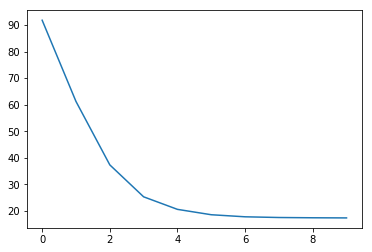

In [53]:
plt.figure()
plt.plot(errorHist[0:10])
plt.show()

Teste: abc
